In [1]:
import sys
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import os
from os.path import exists, join, basename, splitext
from PIL import Image 
import PIL
import shutil

import pandas as pd
import pickle
import argparse
from collections import namedtuple
import numpy as np
from shapely.geometry import Polygon

import json
from tqdm import tqdm

import math
from pathlib import Path, PurePath

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.10.0+cu111 False


In [4]:
!pip install -q pytorch-lightning

     |████████████████████████████████| 525 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 41.3 MB/s 
     |████████████████████████████████| 332 kB 67.4 MB/s 
     |████████████████████████████████| 132 kB 47.9 MB/s 
     |████████████████████████████████| 829 kB 55.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 192 kB 68.9 MB/s 
     |████████████████████████████████| 271 kB 71.1 MB/s 
     |████████████████████████████████| 160 kB 72.6 MB/s 


In [5]:
!pip install -q transformers timm

     |████████████████████████████████| 3.3 MB 5.0 MB/s 
     |████████████████████████████████| 376 kB 57.2 MB/s 
     |████████████████████████████████| 61 kB 339 kB/s 
     |████████████████████████████████| 3.3 MB 40.7 MB/s 
     |████████████████████████████████| 895 kB 26.8 MB/s 


In [6]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from transformers import DetrConfig, DetrForObjectDetection
from transformers import DetrFeatureExtractor

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
git_repo_url = 'https://github.com/facebookresearch/detr.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt

sys.path.append(project_name)

In [9]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50", num_classes = 1)

Downloading:   0%|          | 0.00/274 [00:00<?, ?B/s]

# Model defnition

In [10]:
id2label = {0: 'text'}
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

In [11]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

Downloading:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load pre-trained model

Set the path to the trained model. one trained over 25 epochs can be found here:
https://drive.google.com/file/d/18851SWxvtgSgMN3IO9M1dOcrEobyIBVS/view?usp=sharing

In [12]:
PATH = '/content/drive/MyDrive/ultra_hack/DETR_25.pth'#'/content/DETR_25.pth'

In [13]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Inference on Test set

Set the path to the test images directory

In [14]:
test_im_path = '/content/drive/MyDrive/ultra_hack/train/test'

In [16]:
preds = {}
test_filenames = os.listdir(test_im_path) # get the filenames in test directory eg. 17000.png

for idx in range(len(test_filenames)):
  filename = test_filenames[idx]
  im = Image.open(os.path.join(test_im_path, filename))
  encoding = feature_extractor(im, return_tensors="pt")
  outputs = model(**encoding)

  # keep only predictions of queries with some confidence 
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.85 # can set threshold here. heuristic choice for now

  # rescale bounding boxes
  target_sizes = torch.tensor(im.size[::-1]).unsqueeze(0)
  postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
  bboxes_scaled = postprocessed_outputs[0]['boxes'][keep] # [x1,y1,w,h] format typical of CoCO
  # converting to icdar format [x1,y1,x2,y2,x3,y3,x4,y4] in clockwise direction
  icdar = []
  for i in bboxes_scaled.detach().numpy():
    x1 = i[0]
    y1 = i[1]
    w = i[2]
    h = i[3]
    x2 = x1 + w
    y2 = y1
    x3 = x1 + w
    y3 = y2 + h
    x4 = x1
    y4 = y1 + h
    icdar.append(np.array([x1, y1, x2, y2, x3, y3, x4, y4]))
  preds[filename] = icdar
  if idx % 20 == 0:
    print("Inferring done upto file no: ", idx)

/usr/local/lib/python3.7/dist-packages/transformers/models/detr/modeling_detr.py:423: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


Inferring done upto file no:  0
Inferring done upto file no:  20
Inferring done upto file no:  40
Inferring done upto file no:  60
Inferring done upto file no:  80
Inferring done upto file no:  100
Inferring done upto file no:  120


# Save output

Define an output directory to save the text files for each image

In [29]:
icdar_out_path = '/content/preds_DETR/'

for k, v in preds.items():
  filename = k.split('.')[0] + '.txt'
  np.savetxt(icdar_out_path + filename, v, delimiter=',')

Zip the dir for download

In [30]:
!zip -r /content/preds_DETR.zip /content/preds_DETR

  adding: content/preds_DETR/ (stored 0%)
  adding: content/preds_DETR/17105.txt (deflated 78%)
  adding: content/preds_DETR/17036.txt (deflated 79%)
  adding: content/preds_DETR/17021.txt (deflated 77%)
  adding: content/preds_DETR/17049.txt (stored 0%)
  adding: content/preds_DETR/17131.txt (deflated 76%)
  adding: content/preds_DETR/17088.txt (deflated 74%)
  adding: content/preds_DETR/17104.txt (deflated 76%)
  adding: content/preds_DETR/17116.txt (deflated 69%)
  adding: content/preds_DETR/17107.txt (deflated 70%)
  adding: content/preds_DETR/17065.txt (deflated 61%)
  adding: content/preds_DETR/17027.txt (deflated 78%)
  adding: content/preds_DETR/17037.txt (deflated 78%)
  adding: content/preds_DETR/17073.txt (deflated 69%)
  adding: content/preds_DETR/17032.txt (deflated 79%)
  adding: content/preds_DETR/17102.txt (deflated 77%)
  adding: content/preds_DETR/17092.txt (deflated 60%)
  adding: content/preds_DETR/17000.txt (deflated 80%)
  adding: content/preds_DETR/17059.txt (def

# Visual inspection

In [25]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
    plt.axis('off')
    plt.show()

In [27]:
  filename = test_filenames[0]
  im = Image.open(os.path.join(test_im_path, filename))
  encoding = feature_extractor(im, return_tensors="pt")
  outputs = model(**encoding)

  # keep only predictions of queries with some confidence 
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9 # can set threshold here. heuristic choice for now

  # rescale bounding boxes
  target_sizes = torch.tensor(im.size[::-1]).unsqueeze(0)
  postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
  bboxes_scaled = postprocessed_outputs[0]['boxes'][keep] # [x1,y1,w,h] format typical of CoCO

/usr/local/lib/python3.7/dist-packages/transformers/models/detr/modeling_detr.py:423: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


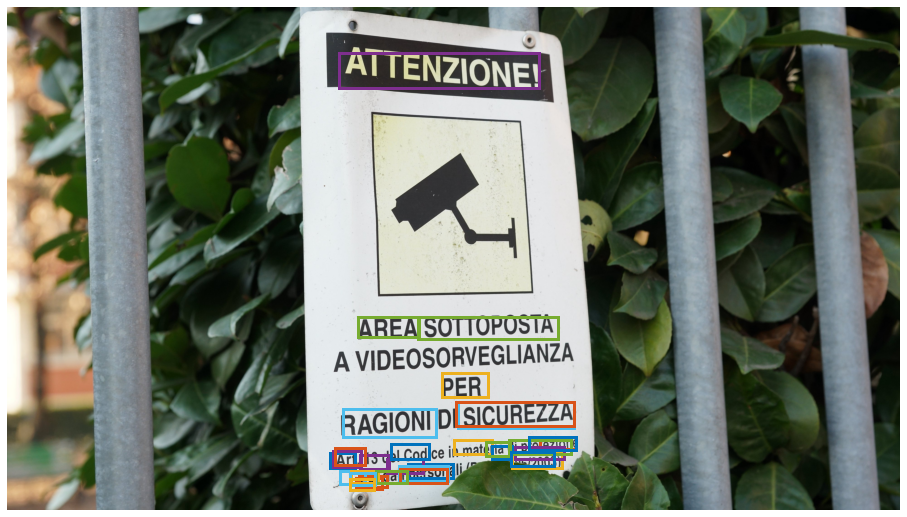

In [28]:
plot_results(im, probas[keep], bboxes_scaled)